# Agentic RAG for Finance Chatbot

In [3]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_experimental.utilities.python import PythonREPL
from langchain_core.tools import Tool
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader

e:\Projects_working\LangGraph_Agents_Nodes\Multi_Tool_Agent_ENV_3.9.0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load Environment Variables
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
google_key = os.getenv("GOOGLE_API_KEY")

# LLM Define

In [3]:
llm = ChatGoogleGenerativeAI(
    google_api_key = os.getenv("GOOGLE_API_KEY"),
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    # other params...
)

# CSV File Loader

In [4]:
file_path = (
    "./dummy_data_for_llm_testing.csv"
)

loader = CSVLoader(file_path=file_path)
data = loader.load()
# print(data)

# for d in data:
#     print(d)

# Embedding The data

In [5]:
model_name = "intfloat/e5-large-v2"

hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
)

print(hf_embeddings)

client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
) model_name='intfloat/e5-large-v2' cache_folder=None model_kwargs={} encode_kwargs={} multi_process=False show_progress=False


In [6]:
persist_directory='./chroma_db'

In [7]:
from langchain_chroma import Chroma

if persist_directory == "./chroma_db":
    vectorstore = Chroma(persist_directory=persist_directory, embedding_function=hf_embeddings)
else:
    vectorstore = Chroma.from_documents(documents=data, persist_directory=persist_directory, embedding=hf_embeddings)

In [8]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(documents=data, persist_directory=persist_directory, embedding=hf_embeddings)

In [9]:
retriever = vectorstore.as_retriever()

In [17]:
# retriever.invoke("what is my january budget of R&D")

In [18]:
# vectorAllData = vectorstore.get(include=['embeddings', 'documents', 'metadatas'])

In [19]:
# print(vectorAllData)

# retriever tool

In [10]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "Financial_data_csv",
    "This is the financial data of user in a csv format. If user want to know something about its financial data then search it and provide details to user.",
)

tools = [retriever_tool]

# Agent State
We will define a graph.

A state object that it passes around to each node.

Our state will be a list of messages.

Each node in our graph will append to it.

In [11]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]


# grade documents for Agentic RAG 

In [12]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
# from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [13]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = llm.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    # llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


# To see what prompt looks like 

In [14]:
from langchain import hub
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# Nodes

In [15]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    # model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Graph
Start with an agent, call_model

Agent make a decision to call a function

If so, then action to call tool (retriever)

Then call agent with the tool output added to messages (state)

In [17]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# PostgresSQL with SupaBase.com

# Adding Memory to Agent Locally

In [ ]:
# from langgraph.checkpoint.memory import MemorySaver

# memory = MemorySaver()
# # Compile
# graph = workflow.compile(checkpointer=memory)

# Display flow

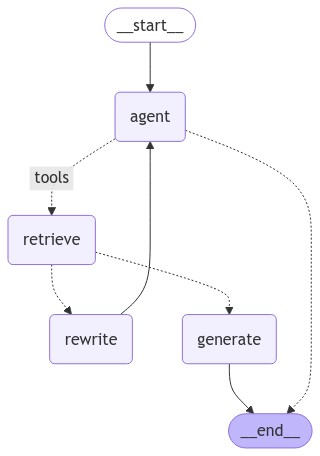

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Using Agent 

In [18]:
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver

DB_URI = os.getenv("Postgres_sql_URL")

async with AsyncPostgresSaver.from_conn_string(DB_URI) as checkpointer:
    await checkpointer.setup()
    graph = workflow.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "1"}}
    
    # Invoke the graph and capture the result
    res = await graph.ainvoke(
        {"messages": [("human", "Do you know my name?")]}, config
    )
    
    # Print the result to the console
    print("Result from graph.ainvoke:")
    print(res)
    
    # Print checkpoint tuples
    checkpoint_tuples = [c async for c in checkpointer.alist(config)]
    print("Checkpoint tuples:")
    for tuple_ in checkpoint_tuples:
        print(tuple_)


Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


---CALL AGENT---
{'name': 'Financial_data_csv', 'description': 'This is the financial data of user in a csv format. If user want to know something about its financial data then search it and provide details to user.', 'parameters': {'type_': 6, 'description': 'Input to the retriever.', 'properties': {'query': {'type_': 1, 'description': 'query to look up in retriever', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
Result from graph.ainvoke:
{'messages': [HumanMessage(content='Do you know my name?', additional_kwargs={}, response_metadata={}, id='83f4f780-de13-45e0-acf6-07b291edee43'), AIMessage(content="I do not have access to your personal information, including your name. My purpose is to help you find information and complete tasks, but I don't store or have access to any private data about you. \n", additio

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad 

In [28]:
async def drop_prepared_statements(conn):
    async with conn.cursor() as cursor:
        await cursor.execute("DEALLOCATE ALL;")

async with AsyncPostgresSaver.from_conn_string(DB_URI) as checkpointer:
    # Use the underlying psycopg connection to drop existing prepared statements
    async with checkpointer.conn.transaction():
        await drop_prepared_statements(checkpointer.conn)
    
    await checkpointer.setup()
    graph = workflow.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "4"}}
    
    res = await graph.ainvoke(
        {"messages": [("human", "What are Expenses in February for marketing department?")]}, config
    )
    
    messages = res.get("messages", [])
    if messages:
        all_contents = [msg.content for msg in messages]  # access content directly from object
        print("All message contents:", all_contents)


Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


---CALL AGENT---
{'name': 'Financial_data_csv', 'description': 'This is the financial data of user in a csv format. If user want to know something about its financial data then search it and provide details to user.', 'parameters': {'type_': 6, 'description': 'Input to the retriever.', 'properties': {'query': {'type_': 1, 'description': 'query to look up in retriever', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
---CHECK RELEVANCE---
{'name': 'grade', 'description': 'Binary score for relevance check.', 'parameters': {'type_': 6, 'properties': {'binary_score': {'type_': 1, 'description': "Relevance score 'yes' or 'no'", 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['binary_score'], 'format_': '', 'description': '', 'nullable':

In [8]:
import psycopg2
import json
url = os.getenv("Postgres_sql_URL")
# PostgreSQL connection details
conn = psycopg2.connect(url)

def fetch_conversation_by_thread(thread_id):
    with conn.cursor() as cursor:
        cursor.execute("SELECT metadata FROM checkpoints WHERE thread_id = %s", (thread_id,))
        result = cursor.fetchone()
        if result:
            # No need for json.loads if the data is already in dict format
            metadata = result[0]  # Directly assign it as the metadata
            return metadata
        else:
            return None

# Example usage
thread_id = '1'
conversation = fetch_conversation_by_thread(thread_id)
if conversation:
    print("Conversation data:", conversation)
else:
    print("No conversation found for this thread_id.")


Conversation data: {'step': -1, 'source': 'input', 'writes': {'__start__': {'messages': [['human', 'Do you know my name?']]}}, 'parents': {}}


In [9]:
import psycopg2
import json
url = os.getenv("Postgres_sql_URL")
# PostgreSQL connection details
conn = psycopg2.connect(url)

def fetch_conversation_by_thread(thread_id):
    with conn.cursor() as cursor:
        cursor.execute("SELECT metadata FROM checkpoints WHERE thread_id = %s", (thread_id,))
        result = cursor.fetchone()
        if result:
            # No need for json.loads if the data is already in dict format
            metadata = result[0]  # Directly assign it as the metadata
            return metadata
        else:
            return None

# Example usage
thread_id = '2'
conversation = fetch_conversation_by_thread(thread_id)
if conversation:
    print("Conversation data:", conversation)
else:
    print("No conversation found for this thread_id.")


Conversation data: {'step': -1, 'source': 'input', 'writes': {'__start__': {'messages': [['human', 'What is the 10 percent of my marketing budget in month of january?']]}}, 'parents': {}}


In [10]:
import psycopg2

# PostgreSQL connection details
conn = psycopg2.connect(url)

def fetch_all_conversations():
    with conn.cursor() as cursor:
        cursor.execute("SELECT thread_id, metadata FROM checkpoints")
        results = cursor.fetchall()
        all_conversations = []
        for row in results:
            thread_id = row[0]  # Thread ID
            metadata = row[1]   # Metadata containing conversation data
            all_conversations.append({"thread_id": thread_id, "conversation": metadata})
        return all_conversations

# Example usage
conversations = fetch_all_conversations()
for conversation in conversations:
    print(f"Thread ID: {conversation['thread_id']}")
    print(f"Conversation: {conversation['conversation']}")
    print("\n")


Thread ID: 1
Conversation: {'step': -1, 'source': 'input', 'writes': {'__start__': {'messages': [['human', 'Do you know my name?']]}}, 'parents': {}}


Thread ID: 1
Conversation: {'step': 0, 'source': 'loop', 'writes': None, 'parents': {}}


Thread ID: 1
Conversation: {'step': 1, 'source': 'loop', 'writes': {'agent': {'messages': [{'id': ['langchain', 'schema', 'messages', 'AIMessage'], 'lc': 1, 'type': 'constructor', 'kwargs': {'id': 'run-7e192c59-832b-4be6-89d3-5468e91d2c2e-0', 'type': 'ai', 'content': "I do not have access to your personal information, including your name. My purpose is to help you find information and complete tasks, but I don't store or have access to any private data about you. \n", 'tool_calls': [], 'usage_metadata': {'input_tokens': 77, 'total_tokens': 119, 'output_tokens': 42}, 'response_metadata': {'finish_reason': 'STOP', 'safety_ratings': [{'blocked': False, 'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE'}, {'blocked': False, 'cat

In [11]:
import psycopg2
import json

# PostgreSQL connection details
conn = psycopg2.connect(url)

def fetch_all_conversations():
    with conn.cursor() as cursor:
        cursor.execute("SELECT thread_id, metadata FROM checkpoints")
        results = cursor.fetchall()
        all_conversations = []
        for row in results:
            thread_id = row[0]  # Thread ID
            metadata = row[1]   # Metadata containing conversation data

            # Try to parse the metadata if it is in JSON format
            if isinstance(metadata, dict):
                conversation_data = metadata
            else:
                conversation_data = json.loads(metadata)
            
            all_conversations.append({"thread_id": thread_id, "conversation": conversation_data})
        return all_conversations

def display_conversations(conversations):
    for conversation in conversations:
        print(f"Thread ID: {conversation['thread_id']}")
        conversation_data = conversation['conversation']

        # Display each message in the conversation
        for step, data in conversation_data.get('writes', {}).items():
            messages = data.get('messages', [])
            for role, message in messages:
                if role == 'human':
                    print(f"User: {message}")
                elif role == 'ai':
                    print(f"Assistant: {message}")
        print("\n")

# Example usage
conversations = fetch_all_conversations()
display_conversations(conversations)


Thread ID: 1
User: Do you know my name?


Thread ID: 1


AttributeError: 'NoneType' object has no attribute 'items'

In [1]:
# test_postgres.py
from postgresSQL import fetch_conversation_by_thread

# Test the fetch_conversation_by_thread function
test_thread_id = "2ee0b7fd-2b9e-4fac-ac6a-8e8cfa9d45d8"  # Replace with a valid thread_id from your data
checkpoints = fetch_conversation_by_thread(test_thread_id)

# Print the output
print("Fetched Checkpoints:")
for checkpoint in checkpoints:
    print(checkpoint)


Fetched Checkpoints:
RealDictRow([('thread_id', '2ee0b7fd-2b9e-4fac-ac6a-8e8cfa9d45d8'), ('checkpoint_id', '1ef91592-8598-64f1-bfff-24c431734e33'), ('parent_checkpoint_id', None), ('type', None), ('checkpoint', {'v': 1, 'id': '1ef91592-8598-64f1-bfff-24c431734e33', 'ts': '2024-10-23T16:09:18.684696+00:00', 'pending_sends': [], 'versions_seen': {'__input__': {}}, 'channel_versions': {'__start__': '00000000000000000000000000000001.0.6302499606610469'}}), ('metadata', {'step': -1, 'source': 'input', 'writes': {'__start__': {'messages': [['human', 'hi']]}}, 'parents': {}})])
RealDictRow([('thread_id', '2ee0b7fd-2b9e-4fac-ac6a-8e8cfa9d45d8'), ('checkpoint_id', '1ef91592-859d-64d8-8000-841dfffb4475'), ('parent_checkpoint_id', '1ef91592-8598-64f1-bfff-24c431734e33'), ('type', None), ('checkpoint', {'v': 1, 'id': '1ef91592-859d-64d8-8000-841dfffb4475', 'ts': '2024-10-23T16:09:18.686741+00:00', 'pending_sends': [], 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000

In [1]:
# test_postgres.py
from postgresSQL import fetch_uploaded_files

fetch_uploaded_files()

Fetched files: [RealDictRow([('file_name', 'dummy_data_for_llm_testing.csv')]), RealDictRow([('file_name', 'dummy_data_for_llm_testing.csv')]), RealDictRow([('file_name', 'dummy_data_for_llm_testing.csv')]), RealDictRow([('file_name', 'dummy_data_for_llm_testing.csv')])]


['dummy_data_for_llm_testing.csv',
 'dummy_data_for_llm_testing.csv',
 'dummy_data_for_llm_testing.csv',
 'dummy_data_for_llm_testing.csv']

In [1]:
from postgresSQL import fetch_uploaded_file_content
fetch_uploaded_file_content("zain_financial_data.csv")

Error fetching file content from database: 0
